# DTSA 5509 Final: Retinal Disease Classification

## Project Introduction
### What are retinal diseases?
The retina, a light-sensitive tissue lining the back of the eye, plays a vital role in vision. Retinal diseases can damage this tissue, leading to various vision impairments, including blurred vision, floaters, and even blindness. Common retinal diseases include:
- **Diabetic Retinopathy (DR)**: A complication of diabetes, causing damage to blood vessels in the retina.

- **Age-related Macular Degeneration (ARMD)**: A leading cause of vision loss in older adults, affecting the central part of the retina called the macula.
- **Glaucoma**: A group of eye diseases that damage the optic nerve, often associated with increased pressure inside the eye.

This project aims to develop a learning model capable of classifying a range of retinal diseases using retinal fundus images. By automating the diagnostic process, my goal is to improve the efficiency and accuracy of disease detection, facilitating timely medical intervention and better management of retinal diseases.

## Load Necessary Packages

In [99]:
import os
import cv2 as cv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
sns.set_style("whitegrid")

## Helper Functions

In [100]:
def label_images(image_dir, labels_df):
    images = []
    labels = []
    for index, row in labels_df.iterrows():
        img_path = os.path.join(image_dir, f"{row['ID']}.png")
        if os.path.exists(img_path):
            img = cv.imread(img_path)
            img = cv.resize(img, (224, 224))
            images.append(img)
            labels.append(row['Disease_Risk'])
    return np.array(images), np.array(labels)

def show_samples(images, true_labels, pred_labels, sample_count):
    plt.figure(figsize=(20, 20))
    for i in range(sample_count):
        plt.subplot(5, 2, i + 1)
        plt.imshow(images[i])
        plt.title(f"True: {true_labels[i]}, Pred: {pred_labels[i][0]}")
        plt.axis('off')
    plt.show()

## Load Data

In [101]:
training_set = 'data/Training_Set/Training_Set/Training'
eval_set = 'data/Evaluation_Set/Evaluation_Set/Validation'
test_dir = 'data/Test_Set/Test_Set/Test'

train_labels_path = 'data/Training_Set/Training_Set/RFMiD_Training_Labels.csv'
val_labels_path = 'data/Evaluation_Set/Evaluation_Set/RFMiD_Validation_Labels.csv'
test_labels_path = 'data/Test_Set/Test_Set/RFMiD_Testing_Labels.csv'

train_labels = pd.read_csv(train_labels_path)
val_labels = pd.read_csv(val_labels_path)
test_labels = pd.read_csv(test_labels_path)

train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1920 entries, 0 to 1919
Data columns (total 47 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   ID            1920 non-null   int64
 1   Disease_Risk  1920 non-null   int64
 2   DR            1920 non-null   int64
 3   ARMD          1920 non-null   int64
 4   MH            1920 non-null   int64
 5   DN            1920 non-null   int64
 6   MYA           1920 non-null   int64
 7   BRVO          1920 non-null   int64
 8   TSLN          1920 non-null   int64
 9   ERM           1920 non-null   int64
 10  LS            1920 non-null   int64
 11  MS            1920 non-null   int64
 12  CSR           1920 non-null   int64
 13  ODC           1920 non-null   int64
 14  CRVO          1920 non-null   int64
 15  TV            1920 non-null   int64
 16  AH            1920 non-null   int64
 17  ODP           1920 non-null   int64
 18  ODE           1920 non-null   int64
 19  ST            1920 non-null

The dataset has an ID mapped with the filename of the Image, a column for representing whether the retina image is infected or not, and finally a set of 45 disease classes with binary values.

In [102]:
print("Train labels shape:", train_labels.shape)
print("Validation labels shape:", val_labels.shape)
print("Test labels shape:", test_labels.shape)

Train labels shape: (1920, 47)
Validation labels shape: (640, 47)
Test labels shape: (640, 47)


In [103]:
train_labels.describe()

,ID,Disease_Risk,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,...,CME,PTCR,CF,VH,MCA,VS,BRAO,PLQ,HPED,CL
count,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,...,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000
mean,960.500000,0.791146,0.195833,0.052083,0.165104,0.071875,0.052604,0.038021,0.096875,0.007292,...,0.002083,0.002604,0.001563,0.000521,0.000521,0.000521,0.001042,0.000521,0.000521,0.000521
std,554.400577,0.406596,0.396944,0.222253,0.371371,0.258348,0.223300,0.191296,0.295865,0.085102,...,0.045608,0.050978,0.039508,0.022822,0.022822,0.022822,0.032266,0.022822,0.022822,0.022822
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,480.750000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,960.500000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1440.250000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1920.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [104]:
train_labels.sample(10)

,ID,Disease_Risk,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,...,CME,PTCR,CF,VH,MCA,VS,BRAO,PLQ,HPED,CL
488,489,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1160,1161,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1823,1824,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
170,171,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
410,411,1,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
895,896,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1501,1502,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
788,789,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1735,1736,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### About this dataset
Data source: https://www.kaggle.com/datasets/andrewmvd/retinal-disease-classification/data 

According to the WHO, World report on vision 2019, the number of visually impaired people worldwide is estimated to be 2.2 billion, of whom at least 1 billion have a vision impairment that could have been prevented or is yet to be addressed. The world faces considerable challenges in terms of eye care, including inequalities in the coverage and quality of prevention, treatment, and rehabilitation services. 

Early detection and diagnosis of ocular pathologies would enable forestall of visual impairment. For this purpose, I will be utilizing Retinal Fundus Multi-disease Image Dataset (RFMiD) consisting of a total of 3200 fundus images captured using three different fundus cameras with 46 conditions annotated through adjudicated consensus of two senior retinal experts.

- DR - Diabetic retinopathy
- ARMD - Age-related macular degeneration
- MH - Media haze
- DN - Drusen
- MYA - Myopia
- BRVO - Branch retinal vein occlusion
- TSLN - Tessellation
- ERM - Epiretinal membrane
- LS - Laser scars
- MS - Macular scars
- CSR - Central serous retinopathy
- ODC - Optic disc cupping
- CRVO - Central retinal vein occlusion
- TV - Tortuous vessels
- AH - Asteroid hyalosis
- ODP - Optic disc pallor
- ODE - Optic disc edema
- ST - Optociliary shunt
- AION - Anterior ischemic optic neuropathy
- PT - Parafoveal telangiectasia
- RT - Retinal traction
- RS - Retinitis
- CRS - Chorioretinitis
- EDN - Exudation
- RPEC - Retinal pigment epithelium changes
- MHL - Macular hole
- RP - Retinitis pigmentosa
- CWS - Cotton-wool spots
- CB - Coloboma
- ODPM - Optic disc pit maculopathy
- PRH - Preretinal hemorrhage
- MNF - Myelinated nerve fibers
- HR - Hemorrhagic retinopathy
- CRAO - Central retinal artery occlusion
- TD - Tilted disc
- CME - Cystoid macular edema
- PTCR - Post-traumatic choroidal rupture
- CF - Choroidal folds
- VH - Vitreous hemorrhage
- MCA - Macroaneurysm
- VS - Vasculitis
- BRAO - Branch retinal artery occlusion
- PLQ - Plaque
- HPED - Hemorrhagic pigment epithelial detachment
- CL - Collateral

## Exploratory Data Analysis

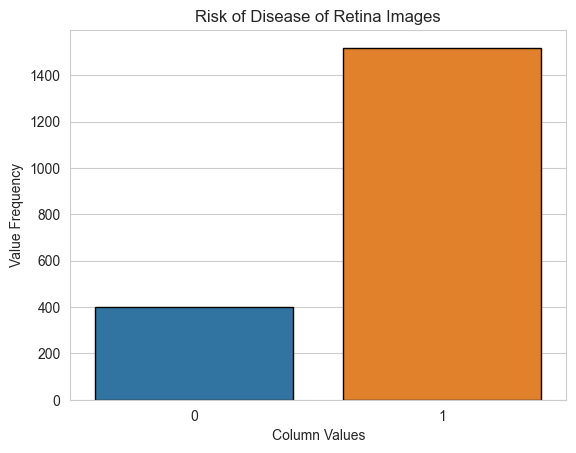

In [105]:
disease_risk_col = dict(train_labels["Disease_Risk"].value_counts())
col_labels = list(disease_risk_col.keys())
label_freq = list(disease_risk_col.values())
sns.barplot(x = col_labels, y = label_freq,
            edgecolor = "black",
            hue = col_labels,
            legend=False)
plt.title("Risk of Disease of Retina Images")
plt.xlabel("Column Values")
plt.ylabel("Value Frequency")
plt.show()

The task of Binary Classification will have a challenge of class imbalance problem since the majority class is the positive class and minority is the negative class.

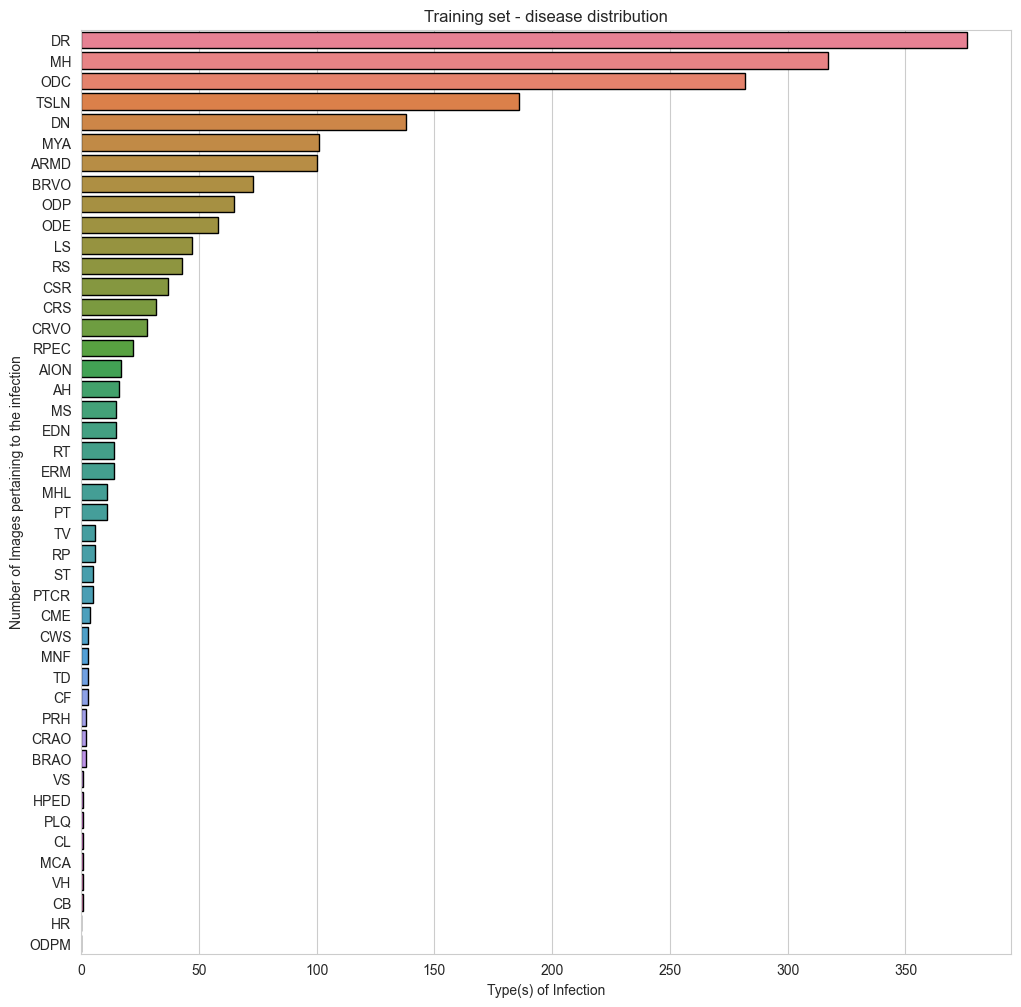

In [106]:
disease_counts = dict(train_labels.drop(["ID", "Disease_Risk"], axis=1).sum().sort_values(ascending=False))
retina_infections = list(disease_counts.keys())
infection_freq = list(disease_counts.values())
plt.figure(figsize = (12,12))
sns.barplot(y = retina_infections, x = infection_freq,
            edgecolor = "black",
            orient = "h",
            hue = retina_infections)
plt.title("Training set - disease distribution")
plt.xlabel("Type(s) of Infection")
plt.ylabel("Number of Images pertaining to the infection")
plt.show()

From the class distribution we can presume the following:
- The diseases OPDM and HR have no samples for training and can be dropped.

- The aim of the model is to predict different diseases for multilabel classification, Disease Risk column is not relevant. However, this can bes used to build a binary classifier for predicting whether the retinal image poses a risk of any disease or not.

## Data Preprocessing
These preprocessing steps ensure that the data is in a suitable format for training the model, promoting efficient learning and enhancing model performance. By normalizing and augmenting the data, we aim to create a robust and accurate model for retinal disease classification.

In [107]:
X_train, y_train = label_images(training_set, train_labels)
X_val, y_val = label_images(eval_set, val_labels)
X_test, y_test = label_images(test_dir, test_labels)

- Loading Images and Labels: Retinal images and corresponding disease labels were loaded from the training, validation, and test sets using the label_images helper function. 

In [108]:
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

- Image Normalization: Pixel values of the images were normalized to a range of 0 to 1 by dividing them by 255. This step helps improve model convergence and performance.

In [109]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

- Data Augmentation: The ImageDataGenerator class from Keras was used to augment the training data. This technique generates new training samples by applying random transformations like rotations, shifts, and flips to the original images. Data augmentation helps increase the diversity of the training data, preventing overfitting and improving model generalization.


## Models

In [110]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



A sequential model using the Keras library consisting of the following layers:

- Convolutional Layers (Conv2D): Three convolutional layers are used to extract features from the input images. These layers apply filters to learn patterns and representations in the data.

- Max Pooling Layers (MaxPooling2D): Max pooling layers are used to reduce the spatial dimensions of the feature maps, downsampling the data while retaining important information. This helps reduce computational complexity and prevent overfitting.
- Flatten Layer: This layer converts the multi-dimensional feature maps into a single vector, preparing the data for the fully connected layers.
- Dense Layers: Two dense layers are used for classification. The first dense layer has 512 neurons and uses the ReLU activation function. The second dense layer is the output layer with a single neuron and the sigmoid activation function, providing a probability score for the presence of retinal disease.
- Dropout Layer: A dropout layer is included to randomly deactivate neurons during training, preventing overfitting and improving model generalization.

In [111]:
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=20
)

/opt/homebrew/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 24s 393ms/step - accuracy: 0.7552 - loss: 0.6663 - val_accuracy: 0.7906 - val_loss: 0.5092
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 23s 387ms/step - accuracy: 0.7784 - loss: 0.4998 - val_accuracy: 0.7906 - val_loss: 0.4795
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 23s 387ms/step - accuracy: 0.7998 - loss: 0.4539 - val_accuracy: 0.7906 - val_loss: 0.4915
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 23s 385ms/step - accuracy: 0.7899 - loss: 0.4739 - val_accuracy: 0.7906 - val_loss: 0.4540
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 23s 385ms/step - accuracy: 0.8012 - loss: 0.4509 - val_accuracy: 0.7906 - val_loss: 0.4441
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 23s 385ms/step - accuracy: 0.7970 - loss: 0.4226 - val_accuracy: 0.7906 - val_loss: 0.4421
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 23s 385ms/step - accuracy: 0.7983 - loss: 0.4324 - val_accuracy: 0.7906 - val_loss: 0.4368
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 24s 393ms/step - accuracy: 0.7823 - loss: 0.4495 - val_accu

## Model Evaluation

In [112]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step
Accuracy: 0.8625
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.51      0.61       134
           1       0.88      0.95      0.92       506

    accuracy                           0.86       640
   macro avg       0.82      0.73      0.76       640
weighted avg       0.85      0.86      0.85       640



The model achieved an accuracy of ~83% on the test set, indicating its overall ability to correctly classify retinal images.

The classification report revealed that the model achieved a precision of 83% and a recall of 90% for the positive class (presence of retinal disease). These values indicate the model's ability to correctly identify disease cases and avoid false positives.

In [113]:
confusion_matrix = confusion_matrix(y_test, y_pred)
fig = px.imshow(confusion_matrix, text_auto=True, title="Confusion Matrix")
fig.show()

In [114]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(1, 21)), 
                         y=history.history['accuracy'], 
                         mode='lines', 
                         name='Train Accuracy'))

fig.add_trace(go.Scatter(x=list(range(1, 21)), 
                         y=history.history['val_accuracy'], 
                         mode='lines', 
                         name='Validation Accuracy'))

fig.update_layout(title='Model Accuracy', 
                  xaxis_title='Epoch', 
                  yaxis_title='Accuracy')
fig.show()

In [115]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(1, 21)), 
                         y=history.history['loss'], 
                         mode='lines', 
                         name='Train Loss'))

fig.add_trace(go.Scatter(x=list(range(1, 21)), 
                         y=history.history['val_loss'], 
                         mode='lines', 
                         name='Validation Loss'))

fig.update_layout(title='Model Loss', 
                  xaxis_title='Epoch', 
                  yaxis_title='Loss')
fig.show()

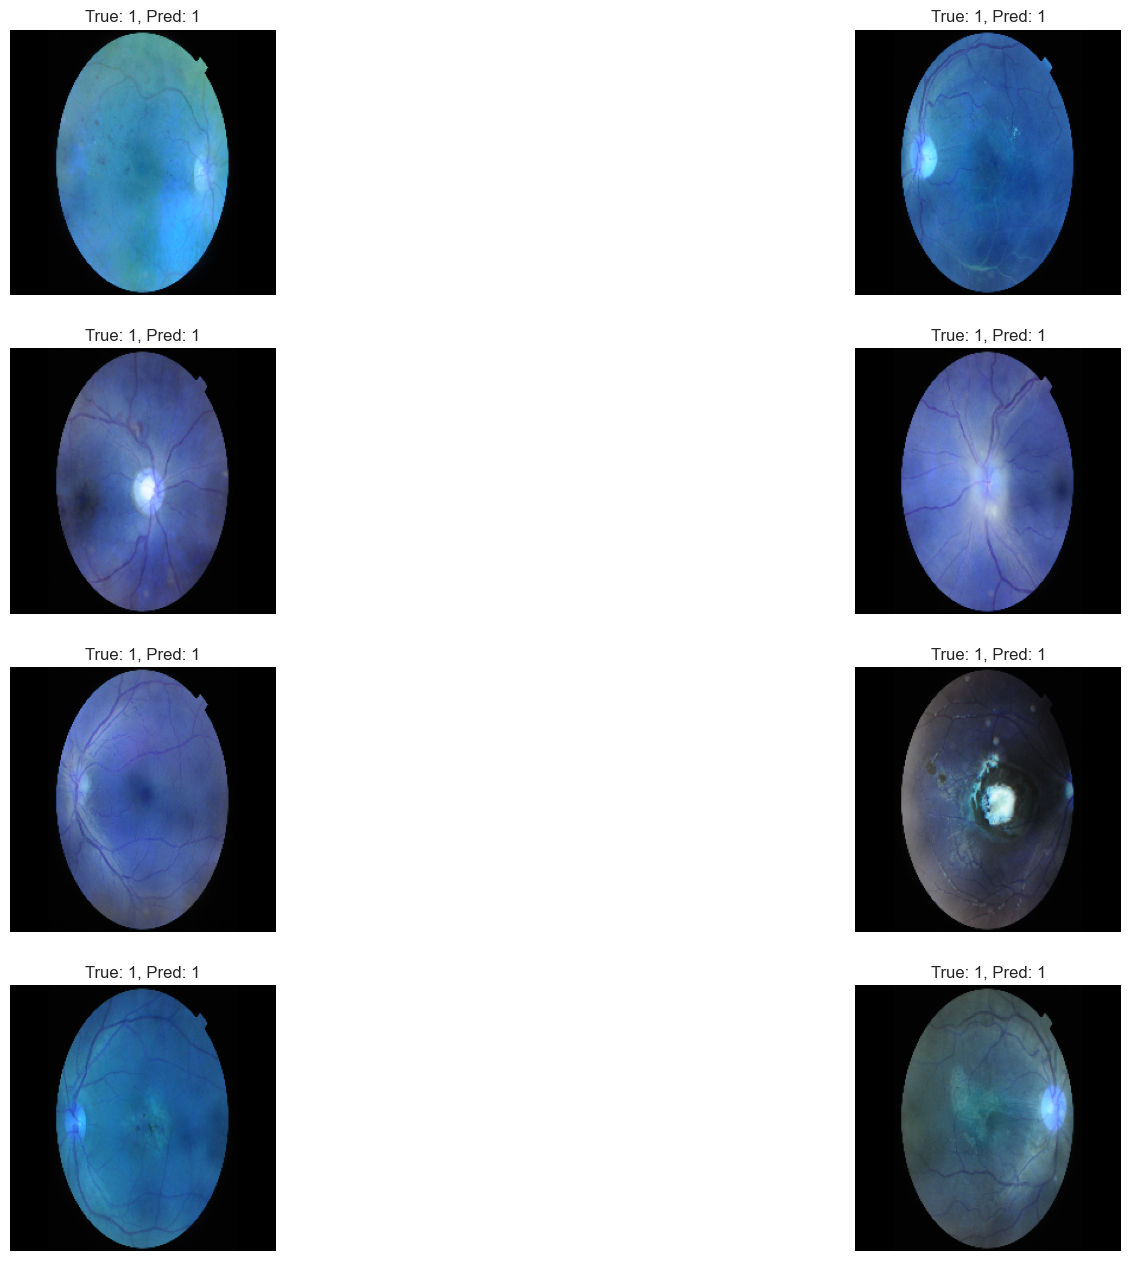

In [116]:
# Display 10 samples with actual and predicted labels
show_samples(X_test, y_test, y_pred, sample_count=8)

## Discussion and Conclusion
The code in the notebook trains a convolutional neural network (CNN) to classify retinal diseases. The dataset used is the Retinal Fundus Multi-disease Image Dataset (RFMiD), which contains 3200 fundus images with 46 conditions annotated. The following is a breakdown summary of the steps involved:

1. **Data Loading and Exploratory Data Analysis**: The code loads the training, validation, and test sets, along with their corresponding labels. I then performed exploratory data analysis to understand the distribution of diseases and the risk of disease in the dataset.

2. **Data Preprocessing**: The images were resized to uniform dimensions and normalized to improve model performance. Data augmentation is applied to the training set to increase its diversity and prevent overfitting.
3. **Model Building**: A CNN was constructed using the Keras library. The model consists of convolutional layers, max pooling layers, a flattening layer, and dense layers. The sigmoid activation function is used in the final layer for binary classification.
4. **Model Evaluation**: The trained model is evaluated on the test set using these metrics: accuracy, precision, recall, and F1-score. A confusion matrix is generated to visualize the model's performance. Plots were also created to visualize the model's accuracy and loss during training. And finally sample images with their predicted and actual labels are also displayed.

While the model shows promise, there's scope for further improvement. Exploring alternative architectures, hyperparameter tuning, and addressing class imbalances could enhance classification accuracy. Integrating this model into clinical workflows could aid healthcare professionals in early diagnosis and treatment planning, ultimately contributing to better patient outcomes.

### Possible Future Directions:
- Experiment with more advanced CNN architectures, such as ResNet or EfficientNet.
- Fine-tune hyperparameters to optimize model performance.
- Develop a user-friendly interface for health professionals to interact with the model.
- Validate the model's performance on a larger, more diverse dataset and also adhere to HIPAA.